In [1]:
#!/usr/bin/python
#import wradlib as wrl
import pylab as pl
from glob import glob
import warnings
warnings.filterwarnings('ignore')
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np

import csv
import os
import datetime
import pandas as pd

#shapefile: GIS vector data format (ESRI)
import shapefile as shp  # Requires the pyshp package
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import netCDF4 as nc4
from datetime import date,timedelta
import plotly.graph_objs as go
import matplotlib.lines as mlines
import seaborn as sns

import importlib
import geopandas as gpd
import xarray as xr
import cartopy.crs as ccrs  # Projections list

#import external functions (need pip install ipynb)
import ipynb.fs.full.HaileventsFunctions as HF

# In this notebook:

- OT detection dataset reading: using netCDF4 to read, cut SPHERA spatial domain and apply parallax correction
- Impact of parallax correction on data, and impact of parallax correction depending on hour of the day
- Write OT data in xarray and plot them with pcolormesh (solved error of geolocalization!)
- Convert xarray to dataframe and to geodataframe setting up geometry
- Select SPHERA data in a spatial window (7x7 SPHERA grid cells) around every OT detection
- Temporal aggregation: consider SPHERA max/min parameters in the 4hours before OT occurrence before spatial matching
- ...
- Collect all OT detections of the set of events and build a unique dataset considering all days together

In [2]:
#Folder address containing data:
fold = '/home/ciccuz/phd/KIT/hail_data/'

In [3]:
#Preliminar parameters:

#lat/lon coords to cover the whole SPHERA domain:
lonmin_S=6; lonmax_S=19; latmin_S=35; latmax_S=49
latplot_S=[latmin_S,latmax_S]; lonplot_S=[lonmin_S,lonmax_S]

#Read the shapefiles:
sf_it = shp.Reader(fold + "hail4_punge/geodata/ITA_adm/ITA_adm0.shp", encoding='latin-1'); srn=5;
sf_de = shp.Reader(fold + "hail4_punge/geodata/DEU_adm/DEU_adm0.shp", encoding='latin-1'); srn=5;
sf_aut = shp.Reader(fold + "hail4_punge/geodata/AUT_adm/AUT_adm0.shp", encoding='latin-1'); srn=5;
sf_che = shp.Reader(fold + "hail4_punge/geodata/CHE_adm/CHE_adm0.shp", encoding='latin-1'); srn=5;
sf_cro = shp.Reader(fold + "hail4_punge/geodata/Croatia/mj788hg8036.shp", encoding='latin-1'); srn=5;
sf_slo = shp.Reader(fold + "hail4_punge/geodata/Slovenia/gk259nt7452.shp", encoding='latin-1'); srn=5;
sf_hun = shp.Reader(fold + "hail4_punge/geodata/Hungary/qh513vs8921.shp", encoding='latin-1'); srn=5;

#With geopandas:
sfg_ita = gpd.read_file(fold + "hail4_punge/geodata/ITA_adm/ITA_adm0.shp", encoding='latin-1')
sfg_deu = gpd.read_file(fold + "hail4_punge/geodata/DEU_adm/DEU_adm0.shp", encoding='latin-1')
sfg_aut = gpd.read_file(fold + "hail4_punge/geodata/AUT_adm/AUT_adm0.shp", encoding='latin-1')
sfg_che = gpd.read_file(fold + "hail4_punge/geodata/CHE_adm/CHE_adm0.shp", encoding='latin-1')
sfg_cro = gpd.read_file(fold + "hail4_punge/geodata/Croatia/mj788hg8036.shp", encoding='latin-1')
sfg_slo = gpd.read_file(fold + "hail4_punge/geodata/Slovenia/gk259nt7452.shp", encoding='latin-1')
sfg_hun = gpd.read_file(fold + "hail4_punge/geodata/Hungary/qh513vs8921.shp", encoding='latin-1')


#maps limits whole SPHERA domain
x_lim_S=lonplot_S
y_lim_S=latplot_S

x_lim = x_lim_S
y_lim = y_lim_S

#maps limits for Graz event (sample case):
xlimG = [12,17]
ylimG = [46,49]

clonsel, clatsel, csizesel, cnamesel, ckindsel = HF.HF_cities(latmin_S,latmax_S,lonmin_S,lonmax_S)

sf_geo = [sfg_ita,sfg_aut]

### - Read OT data with netCDF:

Methodology employed for now (HJ):

- Read netcdf dataset using netCDF4 library storing OT probability, lons and lats and timings (check here for some docu: https://towardsdatascience.com/read-netcdf-data-with-python-901f7ff61648)

A NetCDF file has three basic parts: metadata, dimensions and variables
- Data manipulation (**understand what is done!**), with parallax correction, and produce as output 3 masked arrays for OTprob, lons and lats
- Plot OT prob. on geographic maps with colorcoding using matplotlib.pylab.pcolor

In [4]:
"""
29 August 2016 (Torino + Graz)
"""
day=2016242; year_u=2016; mon_u=8; day_u=29; lonmin=6; lonmax=17; latmin=44; latmax=49 #for Graz
#lonmin=6.5; lonmax=9; latmin=44; latmax=46     for Torino
#fold_out = 'Torino_'+"{:02d}".format(day_u)+'-'+"{:02d}".format(mon_u)+'-'+str(year_u)

hhmin=13; hhmax=14;

latplot=[latmin,latmax]; lonplot=[lonmin,lonmax]; dxstr=.1

In [5]:
"""
Read OT data
"""

#SETUP OT parameters:

#otpref='NASALARC_MET08_SEVIRI_OTDETECTION_'
#otpref='NASALARC_MET09_SEVIRI_OTDETECTION_'
otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'     #2016 2017
#otpref='NASALARC_MET11_SEVIRI_OTDETECTION_'    #2018
#otpref='A'
otsep = '_'
othstart = '0000'
#names for the OT data files used to read them
otdir=fold + f'data/OT_SEVIRI_data_2016-2018/2016/{day}/';  #OT_SEVIRI_data/
otposf='.nc';

ncfile=otdir+otpref+str(day)+otsep+othstart+otposf;

#Read 1 netcdf OT data
f = nc4.Dataset(ncfile,'r')

In [6]:
f

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Geostationary Visible and Infrared Imager Deep Convective Storm Detection and Characterization Dataset From NASA Langley Research Center
    summary: This file contains products designed to identify 1) deep convective anvil clouds, 2) cold or textured updraft and gravity wave regions embedded within the anvils, and 3) areas where ice crystal icing due to high ice water content could occur using visible and infrared imager observations and numerical model analyses.
Algorithm development was sponsored by the NOAA GOES-R Risk Reduction Research Program, the NASA ROSES Severe Weather Research Program, the NASA Applied Sciences Disasters Program, the NASA Earth Venture DCOTSS mission, and the NASA ARMD Advanced Air Transport Technology Project.
    reference1: Khlopenkov, K. V., K. M. Bedka, J. W. Cooney, and K. Itterly, 2021: Recent Advances in Detection of Overshooting Cloud Tops from Longwave

In [49]:
f.variables['latitude']

<class 'netCDF4._netCDF4.Variable'>
float32 latitude(nlines)
    long_name: Latitude
    scale_factor: 57.29578
    _FillValue: -999.0
    units: degrees_north
unlimited dimensions: 
current shape = (420,)
filling on

In [50]:
f.variables['ot_probability']

<class 'netCDF4._netCDF4.Variable'>
uint8 ot_probability(time, nlines, npixels)
    long_name: Overshooting Top Probability
    valid_range: [  1 100]
    units: unitless
    _FillValue: 0
    coordinates: longitude latitude time
    scale_factor: 0.01
unlimited dimensions: 
current shape = (1, 420, 560)
filling on

In [7]:
f.variables['ir_brightness_temperature']

<class 'netCDF4._netCDF4.Variable'>
uint16 ir_brightness_temperature(time, nlines, npixels)
    long_name: IR Brightness Temperature Image
    valid_range: [15000 35000]
    units: degrees_Kelvin
    scale_factor: 0.01
    _FillValue: 65535
    coordinates: longitude latitude time
unlimited dimensions: 
current shape = (1, 420, 560)
filling on

In [51]:
#Print dimensions of dataset:
for dim in f.dimensions.values():
    print(dim)

<class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 1
<class 'netCDF4._netCDF4.Dimension'>: name = 'nlines', size = 420
<class 'netCDF4._netCDF4.Dimension'>: name = 'npixels', size = 560


### - Limit OT data to SPHERA spatial domain:

- Reduce the spatial domain before operating on the files: from lat=[30.02,64.98] & lon=[-9.98,29.98] limit the domain to SPHERA: lat=[35,49] & [6,19]

In this way instead of using matrices with 980x1120 (lons x lats) elements we consider matrices having **392x364** elements! **IMPLEMENTED** in the function:

In [52]:
cpclat, cpclon, otpmax, dtmin, ot_timing = HF.HF_OTdata(day,hhmin,hhmax,otpref,otdir)

##### - Consider the reduced domain (SPHERA) but without applying parallax correction:

In [53]:
#store OT probability (%) data and relative lat,lon
ref=f.variables['ot_probability'][:]    #OT data with 3 dimensions: 1 temporal (fictitious), and 2 spatial (lat,lon)
lons=f.variables['longitude'][:]        #lon data with 1 dimension: itself
lats=f.variables['latitude'][:]         #lat data "


#FILTER OUT OT DETECTIONS OUTSIDE SPHERA DOMAIN: extract spatial subset over SPHERA spatial domain only:
lons_S_ind = np.where((lons.data > lonplot_S[0]) & (lons.data < lonplot_S[1]))[0]
lats_S_ind = np.where((lats.data > latplot_S[0]) & (lats.data < latplot_S[1]))[0]
ref_S = f.variables['ot_probability'][:,lats_S_ind,lons_S_ind]

#substitute full lat/lon variables with subset data:
lons = lons[lons_S_ind]
lats = lats[lats_S_ind]

#close file
#f.close()

#create coordinate matrix from the two coordinate vectors of lats and lons:
longg, latg = np.meshgrid(lons, lats)  #longg: 980*1120 long arrays with the same range of longitudes covered; 
                                       #latg: 980*1120 long arrays having a unique value of lats in the same array
                                       #and progressively increasing value at every array
#make copies of the matrix:
cpclon_noPcor=1.*longg;cpclat_noPcor=1.*latg;

#create matrices of 0s and 9999s with the same dimensions of the grid considered (for storing OT variables)
refmax=np.zeros([len(lats),len(lons)]); otpmax_noPcor=refmax;
irbmin=refmax+9999; #print refmax.shape
dtmin=refmax+9999;
virmax=refmax;
otvmax=refmax;otimax=refmax;
zarr=np.zeros([1,len(lats),len(lons)]);
t_ot=[]
ot_timing=[]

#point to OT data files divided in 15 minutes intervals:
otfiles = sorted(glob(otdir+otpref+str(day)+otsep+"*"+otposf));

#Cycle to read and store the OT data and related variables from the set of separated files
for ncfile in otfiles[:]:
    hh=int(ncfile[-7:-5])  #hour

    #Condition on the hour of the day around the event [hhmin,hhmax]
    if (hh>=hhmin)&(hh<hhmax):   # considering <=hhmax 2 hours are included:e.g. from hhmin(3.00pm)to 
                                  #hhmax(4.59pm)! -> consider <hhmax to retain only from 3.00 to 3.59!
        vars=[];                  
        print(ncfile)
        
        f = nc4.Dataset(ncfile,'r');
        for iv in f.variables.items():
            vars.append(iv[0])

        #initialize variables with zero arrays (zarr):
        dtemp=zarr+9999;  #Delta temp: IR brightness temp (cloud top) - tropopause temperature (to quantify the vertical exstension, but not very robust, better result with difference between OT cloud and anvil cloud (not included here, new version of Bedka))
        otv=zarr;         #OT rating visible (?)
        oti=zarr;         #OT rating infrared (?)
        vir=zarr;         #visible reflectance

        #Parallax correction for OT: these coefficients are equal in every netcdf file
        pclat=f.variables['parallax_correction_latitude'][:,lats_S_ind,lons_S_ind];
        pclon=f.variables['parallax_correction_longitude'][:,lats_S_ind,lons_S_ind];

        #OT probability
        otp=f.variables['ot_probability'][:,lats_S_ind,lons_S_ind];
        otp[(1-np.isfinite(otp[:]))>0]=0.;  #set to 0 all OTprob values exceeding 1 (i.e. 100% OT probability)

        #store timing of max OT probability
        t_ot.append(max((otp>.5)*f.variables['time']))

        ot_timing.append(f.variables['time'].date_time_stamp)
        
        #print(ot_timing)
        #Conditions if variables are missing: set values to 0 or 9999
        if np.any('visible_reflectance' in vars):
            vir=f.variables['visible_reflectance'][:,lats_S_ind,lons_S_ind];
            vir[(1-np.isfinite(vir[:]))>0]=0; 
        if np.any('ot_rating_ir' in vars):
            oti=f.variables['ot_rating_ir'][:,lats_S_ind,lons_S_ind]; #oti=oti/256.;
            oti[(1-np.isfinite(oti[:]))>0]=0; 
        if np.any('ot_rating_visible' in vars):
            otv=f.variables['ot_rating_visible'][:,lats_S_ind,lons_S_ind]; #otv=otv.;
            otv[(1-np.isfinite(otv[:]))>0]=0; 
        if np.any('tropopause_temperature' in vars):
            tpt=f.variables['tropopause_temperature'][:,lats_S_ind,lons_S_ind];
            tpt[(1-np.isfinite(tpt[:]))>0]=0;   
        if np.any('ir_brightness_temperature' in vars):
            irb=f.variables['ir_brightness_temperature'][:,lats_S_ind,lons_S_ind];
            irb[(1-np.isfinite(irb[:]))>0]=9999; 
            dtemp=irb-tpt;
        f.close()

        #Apply parallax correction:
        selmax=irb[0,:,:]<irbmin;       #what is this needed for as irbmin is a matrix of 9999?
        #cpclat[selmax]=pclat[0,selmax]; # additive parallax correction coefficient in latitudes
        #cpclon[selmax]=pclon[0,selmax]; # additive parallax correction coefficient in longitudes

        otpmax_noPcor=np.maximum(otpmax_noPcor, otp[0,:,:]*(dtemp[0,:,:]<0))  #max OT prob. between the previous otpmax and OT 
                                                #prob. matrix * delta temperature matrix with negative values
        irbmin=np.minimum(irbmin, irb[0,:,:])  #minimum infrared brightness temperature (do retain the coldest pixel of the day)
        dtmin=np.minimum(dtmin, dtemp[0,:,:])  #minimum delta temperature
        otimax=np.maximum(otimax, oti[0,:,:])  #maximum OT rating infrared 
        otvmax=np.maximum(otvmax, otv[0,:,:])  #maximum OT rating visible
        virmax=np.maximum(virmax, vir[0,:,:])  #maximum visible reflectance

#Add parallax correction coefficient to lat/lon coordinates
cpclat_noPcor=latg  #cpclat+
cpclon_noPcor=longg #cpclon+
 
otpmax_noPcor[otpmax_noPcor<5e-1]=np.nan  #condition on OT max prob.: set smaller values than 5e-1 to NaN
"""
Condition on dtmin: retain only values <20°C otherwise problems in plotting (WHy???)
"""
dtmin[dtmin>20]=np.nan    #dtmin>50

/home/ciccuz/phd/KIT/hail_data/data/OT_SEVIRI_data_2016-2018/2016/2016242/NASALARC_MET10_SEVIRI_OTDETECTION_2016242_1300.nc
/home/ciccuz/phd/KIT/hail_data/data/OT_SEVIRI_data_2016-2018/2016/2016242/NASALARC_MET10_SEVIRI_OTDETECTION_2016242_1315.nc
/home/ciccuz/phd/KIT/hail_data/data/OT_SEVIRI_data_2016-2018/2016/2016242/NASALARC_MET10_SEVIRI_OTDETECTION_2016242_1330.nc
/home/ciccuz/phd/KIT/hail_data/data/OT_SEVIRI_data_2016-2018/2016/2016242/NASALARC_MET10_SEVIRI_OTDETECTION_2016242_1345.nc


### -Quantify the impact of parallax correction:

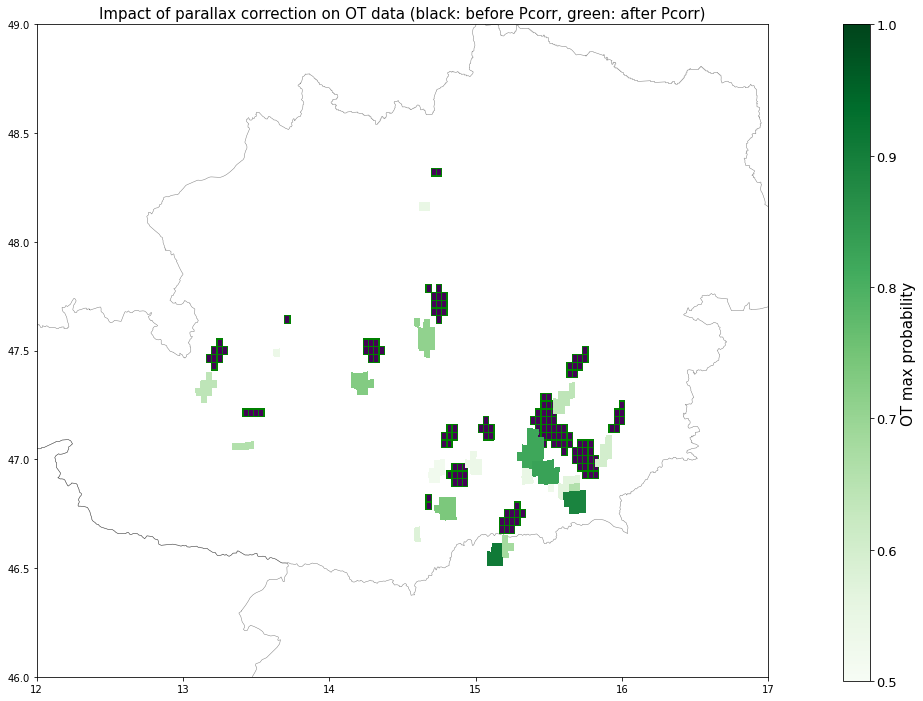

In [13]:
fig, ax = plt.subplots(figsize = (15,12))

plt.xlim([14.5,15.5])
plt.ylim([46.5,47.5])

plt.xlim([12,17])
plt.ylim([46,49])

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

#NO PARALLAX CORRECTION
cm=pl.pcolor(cpclon_noPcor,cpclat_noPcor,otpmax_noPcor,color="green",vmin=0,vmax=100, zorder=2, alpha=1)
#WITH PARALLAX CORRECTION
cm=pl.pcolor(cpclon,cpclat,otpmax,cmap="Greens",vmin=0,vmax=100, zorder=3, alpha=1)

plt.title('Impact of parallax correction on OT data (black: before Pcorr, green: after Pcorr)', 
          loc='center', fontsize=15);

pl.clim([0.5,1])
cb_ot_ax = fig.add_axes([0.92, .12, .025, .76])
cb_ot = pl.colorbar(cax=cb_ot_ax)
cb_ot.ax.tick_params(axis='both', which='major', labelsize=13)
cb_ot.ax.set_ylabel('OT max probability', fontsize=15);

#plt.savefig('/home/ciccuz/phd/KIT/scripts/plots/PROBLEM_ParallaxCorr.png', dpi=300, bbox_inches='tight')

**(Quantify the impact of parallax correction depending on hour of the day)**: 

must upload OT_dict to run this code (look at the end of the notebook)

NameError: name 'OT_dict' is not defined

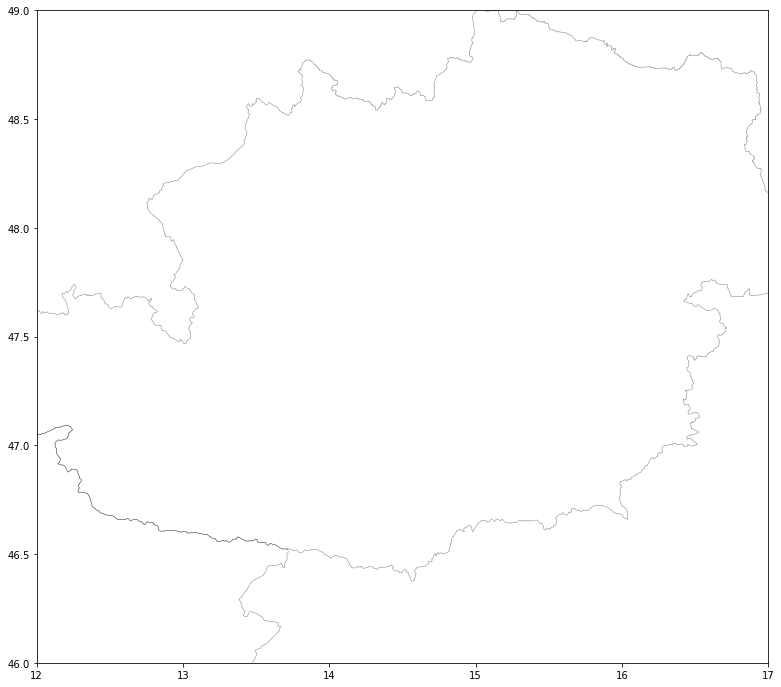

In [14]:
fig, ax = plt.subplots(figsize = (15,12))

plt.xlim([14.5,15.5])
plt.ylim([46.5,47.5])

plt.xlim([12,17])
plt.ylim([46,49])

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

#PARALLAX CORRECTION AT 00
pl.pcolor(OT_dict[14]['cpclon'],OT_dict[14]['cpclat'],OT_dict[14]['otpmax'],color="green",vmin=0,vmax=100, 
             zorder=2, alpha=1)
#PARALLAX CORRECTION AT 12
pl.pcolor(OT_dict[0]['cpclon'],OT_dict[0]['cpclat'],OT_dict[14]['otpmax'],cmap="Greens",vmin=0,vmax=100, 
             zorder=3, alpha=1)

plt.title('Impact of hour of the day on parallax correction grid \n (black: grid and OT at 14, green: grid at 23 OT at 14)', 
          loc='center', fontsize=18);

pl.clim([0.5,1])
cb_ot_ax = fig.add_axes([0.92, .12, .025, .76])
cb_ot = pl.colorbar(cax=cb_ot_ax)
cb_ot.ax.tick_params(axis='both', which='major', labelsize=13)
cb_ot.ax.set_ylabel('OT max probability', fontsize=15);

#plt.savefig('/home/ciccuz/phd/KIT/scripts/plots/PROBLEM_ParallaxCorr_TIME.png', dpi=300, bbox_inches='tight')

 - Count number of OT detections over the domain (<span style="color:red"> REMEMBER: some OTs are detected in the same place at different times!! so these are counted twice, thrice,... </span>)

In [15]:
len(otpmax.data[np.isnan(otpmax.data) == False])

145

#### - Reading original netcdf file with xarray:
(not useful for now as the data are modified with pcorr, but just to know how to)

In [55]:
#read dataset with xarray
f_xr = xr.open_dataset(ncfile)  
f_xr

<xarray.Dataset>
Dimensions:                                         (time: 1, nlines: 420,
                                                     npixels: 560)
Coordinates:
  * time                                            (time) datetime64[ns] 201...
    latitude                                        (nlines) float32 ...
    longitude                                       (npixels) float32 ...
Dimensions without coordinates: nlines, npixels
Data variables: (12/17)
    scan_time                                       (nlines) datetime64[ns] ...
    ir_brightness_temperature                       (time, nlines, npixels) float32 ...
    ot_probability                                  (time, nlines, npixels) float32 ...
    ot_id_number                                    (time, nlines, npixels) float32 ...
    hiwc_probability                                (time, nlines, npixels) float32 ...
    distance_to_overshooting_top                    (time, nlines, npixels) float32 ...
    ...                                              ...
    cloud_top_height                                (time, nlines, npixels) float32 ...
    tropopause_height                               (time, nlines, npixels) float32 ...
    tropopause_pressure                             (time, nlines, npixels) float32 ...
    cloud_top_pressure                              (time, nlines, npixels) float32 ...
    cloud_top_potential_temperature                 (time, nlines, npixels) float32 ...
    ir_anvil_detection                              (time, nlines, npixels) float32 ...
Attributes: (12/23)
    title:                        Geostationary Visible and Infrared Imager D...
    summary:                      This file contains products designed to ide...
    reference1:                   Khlopenkov, K. V., K. M. Bedka, J. W. Coone...
    reference2:                   Cooney, J. W., Bedka, K. M., Bowman, K. P.,...
    reference3:                   Yost, C. R., Bedka, K. M., Minnis, P., Nguy...
    creator_name:                 Kristopher Bedka and Konstantin Khlopenkov
    ...                           ...
    geospatial_lat_max:            49.98
    geospatial_lon_min:             4.02
    geospatial_lon_max:            23.98
    time_coverage_start:          2016-08-29T23:57:33Z
    time_coverage_end:            2016-08-29T23:56:25Z
    numerical_model_data_source:  MERRA-2

In [15]:
#convert xarray dataset to pandas dataframe
df_f_xr = f_xr.to_dataframe()
df_f_xr

latitude  longitude  \
time                nlines npixels                         
2016-08-29 23:45:00 0      0        64.982140  -9.982143   
                           1        64.982140  -9.946429   
                           2        64.982140  -9.910715   
                           3        64.982140  -9.875000   
                           4        64.982140  -9.839286   
...                                       ...        ...   
                    979    1115     30.017859  29.839287   
                           1116     30.017859  29.874998   
                           1117     30.017859  29.910713   
                           1118     30.017859  29.946428   
                           1119     30.017859  29.982143   

                                                       scan_time  \
time                nlines npixels                                 
2016-08-29 23:45:00 0      0       2016-08-29 23:59:36.650956800   
                           1       2016-08-29 23:59:36.650956800   
                           2       2016-08-29 23:59:36.650956800   
                           3       2016-08-29 23:59:36.650956800   
                           4       2016-08-29 23:59:36.650956800   
...                                                          ...   
                    979    1115    2016-08-29 23:57:19.866529792   
                           1116    2016-08-29 23:57:19.866529792   
                           1117    2016-08-29 23:57:19.866529792   
                           1118    2016-08-29 23:57:19.866529792   
                           1119    2016-08-29 23:57:19.866529792   

                                    ir_brightness_temperature  ot_probability  \
time                nlines npixels                                              
2016-08-29 23:45:00 0      0                       272.079987             NaN   
                           1                       272.320007             NaN   
                           2                       272.440002             NaN   
                           3                       272.369995             NaN   
                           4                       272.290009             NaN   
...                                                       ...             ...   
                    979    1115                           NaN             NaN   
                           1116                           NaN             NaN   
                           1117                           NaN             NaN   
                           1118                           NaN             NaN   
                           1119                           NaN             NaN   

                                    ot_id_number  hiwc_probability  \
time                nlines npixels                                   
2016-08-29 23:45:00 0      0                 NaN              0.11   
                           1                 NaN              0.11   
                           2                 NaN              0.11   
                           3                 NaN              0.11   
                           4                 NaN              0.11   
...                                          ...               ...   
                    979    1115              NaN               NaN   
                           1116              NaN               NaN   
                           1117              NaN               NaN   
                           1118              NaN               NaN   
                           1119              NaN               NaN   

                                    distance_to_overshooting_top  \
time                nlines npixels                                 
2016-08-29 23:45:00 0      0                                 NaN   
                           1                                 NaN   
                           2                                 NaN   
                           3                                 NaN  

### - Construct xarray dataset to store post-processed OT files:

- <span style="color:red"> Understand if it's worth to convert from numpy.MaskedArray format to Geopandas DataFrames, and plot with it (I think this should be useful when designing the filter for OT data) </span> 

READ SOME STUFF:
- https://stackoverflow.com/questions/46332479/store-netcdf-data-in-geodataframe
- https://arbolmarket.medium.com/working-with-geospatial-data-in-python-a5ad984c1161

SCHEMATIC IDEA ON HOW TO PROCEED:

<span style="color:blue"> **INPUT**: original OT netcdf files (every 15 mins but 4 files aggregated over 1 hour or over more hours)</span>  -> 

<span style="color:green"> **Process the data** (filter spatial domain, parallax correction, extract only useful variables (lat,lon,otmaxprob,ot_timing))</span> -> 

<span style="color:blue">**OUTPUT** 2-dimensional masked arrays (cpclat,cpclon,otpmax, dtmin?, ot_timing)</span> -> 

**THEN**: Use xarray to recombine the three arrays to form a unique dataset (https://docs.xarray.dev/en/stable/user-guide/combining.html) (<span style="color:red">and then convert to geopandas?</span>)

<span style="color:blue">**WATCH OUT**</span>: also ot_timing must be included to get info on timing! FOr the moment, considering only hourly aggregations, the four OT files avery 15mins are linked to the first hour of the aggregation (e.g. 13.00,13.15,13.30,13,45 -> 13) so only ot_timing[0] is considered, <span style="color:red">evaluate later how to proceed for multi-hours aggregations (if considered but i think not since SPHERA data are also hourly it makes sense to consider 1-h frequency!)</span>

In [57]:
#Read multi-dim xarray containing three arrays otpmax, cpclat and cpclon (already corrected for parallax factor!)
#WITH DATASET: BETTER
xr_OT = xr.Dataset(data_vars=None, 
                   coords=dict(
                       lon=(["xlon", "xlat"], cpclon),
                       lat=(["xlon", "xlat"], cpclat),
                       time=ot_timing[0],
                   ),
                   attrs=dict(
                   description="OT max probability over SPHERA domain accumulated over the hour indicated in time",
                   units="%",
               ),
)      

xr_OT

<xarray.Dataset>
Dimensions:  (xlon: 392, xlat: 364)
Coordinates:
    lon      (xlon, xlat) float32 5.99 6.026 6.061 6.097 ... 18.85 18.89 18.93
    lat      (xlon, xlat) float32 48.85 48.85 48.85 48.85 ... 34.94 34.94 34.94
    time     <U20 '2016-08-29T13:00:00Z'
Dimensions without coordinates: xlon, xlat
Data variables:
    *empty*
Attributes:
    description:  OT max probability over SPHERA domain accumulated over the ...
    units:        %

In [58]:
#set otpmax variable starting from lat array:
xr_OT['otpmax'] = xr_OT.lat*np.nan
xr_OT.otpmax.values = otpmax
xr_OT

<xarray.Dataset>
Dimensions:  (xlon: 392, xlat: 364)
Coordinates:
    lon      (xlon, xlat) float32 5.99 6.026 6.061 6.097 ... 18.85 18.89 18.93
    lat      (xlon, xlat) float32 48.85 48.85 48.85 48.85 ... 34.94 34.94 34.94
    time     <U20 '2016-08-29T13:00:00Z'
Dimensions without coordinates: xlon, xlat
Data variables:
    otpmax   (xlon, xlat) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  OT max probability over SPHERA domain accumulated over the ...
    units:        %

In [59]:
#set attributes of xr dataset:
#dssm["lon"] = (("lon"), dssm.lon)
xr_OT["lon"].attrs["long_name"] = "longitude"
xr_OT["lon"].attrs["units"] = "degree_east"
xr_OT["lon"].attrs["axis"] = "X"

#dssm["lat"] = (("lat"), dssm.lat)
xr_OT["lat"].attrs["long_name"] = "latitude"
xr_OT["lat"].attrs["units"] = "degree_north"
xr_OT["lat"].attrs["axis"] = "Y"

In [60]:
xr_OT

<xarray.Dataset>
Dimensions:  (xlon: 392, xlat: 364)
Coordinates:
    lon      (xlon, xlat) float32 5.99 6.026 6.061 6.097 ... 18.85 18.89 18.93
    lat      (xlon, xlat) float32 48.85 48.85 48.85 48.85 ... 34.94 34.94 34.94
    time     <U20 '2016-08-29T13:00:00Z'
Dimensions without coordinates: xlon, xlat
Data variables:
    otpmax   (xlon, xlat) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  OT max probability over SPHERA domain accumulated over the ...
    units:        %

In [61]:
#find out where are min/max values ot ot probability (only one value but there are more with the same max/min val!!)
xr_OT.isel(xr_OT.otpmax.argmax(...))

<xarray.Dataset>
Dimensions:  ()
Coordinates:
    lon      float32 15.11
    lat      float32 46.61
    time     <U20 '2016-08-29T13:00:00Z'
Data variables:
    otpmax   float64 0.92
Attributes:
    description:  OT max probability over SPHERA domain accumulated over the ...
    units:        %

**Take a look at this**:
how to work with multidimensional geographic data "physical coordinates which differ from their logical coordinates": https://docs.xarray.dev/en/stable/examples/multidimensional-coords.html

In our case xlon and xlat are the logical coordinates (a double index (i,j) over x and y) while the physical coordinates are lon and lat

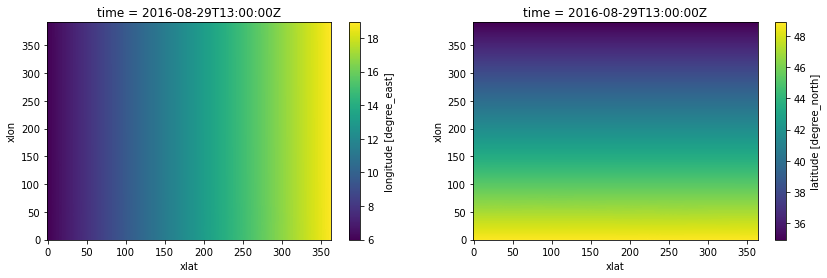

In [21]:
#plot the coordinates variables (lat,lon depending on their spatial indices xlat,xlon)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))
xr_OT.lon.plot(ax=ax1)
xr_OT.lat.plot(ax=ax2);

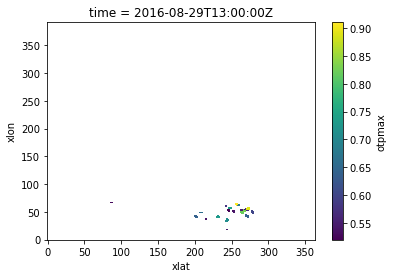

In [22]:
#plot otpmax data without specifying anything: plot made considering indices xlat,xlon instead of actual coordinates
xr_OT.otpmax.plot()

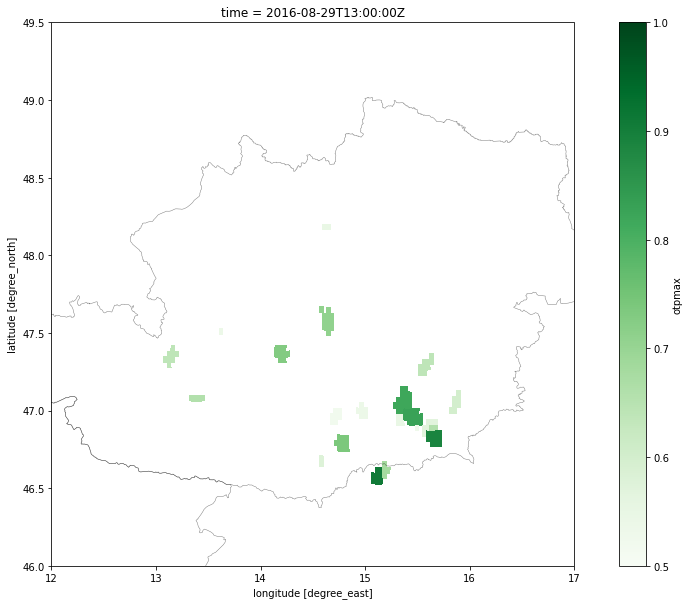

In [23]:
#plot otpmax data specifying projection and what to use as geoloc data:
plt.figure(figsize=(16, 10))

ax = plt.axes(xlim=xlimG, ylim=ylimG, projection=ccrs.PlateCarree())

xr_OT.otpmax.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='Greens',vmin=0.5,vmax=1.0, #add_colorbar=False
)

plt.xticks(np.arange(xlimG[0], xlimG[1]+1, 1))
plt.yticks(np.arange(ylimG[0], ylimG[1]+1, .5))

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

cb_ot_ax = fig.add_axes([0.78, .12, .025, .76])
cb_ot.ax.tick_params(axis='both', which='major', labelsize=13)
cb_ot.ax.set_ylabel('OT max probability', fontsize=15);


**Compare last plot with the previous one plotted without xr dataset and using pcolor instead of pcolormesh:**

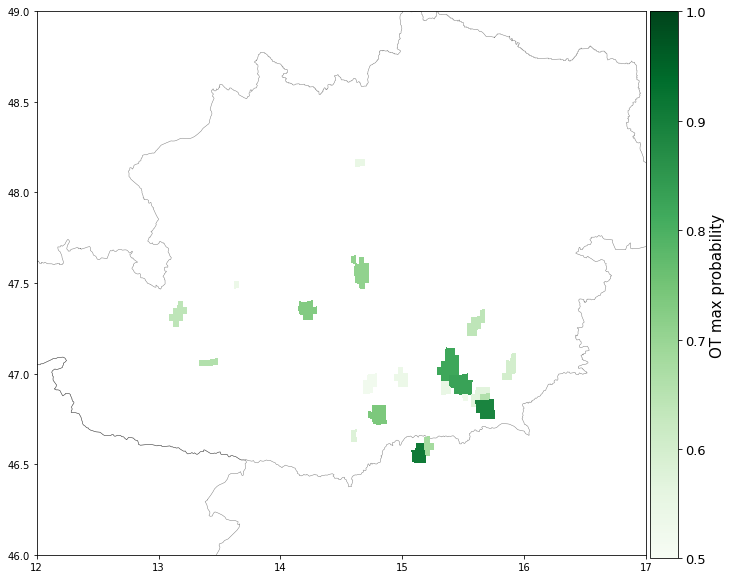

In [24]:
fig, ax = plt.subplots(figsize = (16,10))

plt.xlim(xlimG)
plt.ylim(ylimG)

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

#WITH PARALLAX CORRECTION
cm=pl.pcolor(cpclon,cpclat,otpmax,cmap="Greens",vmin=0,vmax=100, zorder=3, alpha=1)

pl.clim([0.5,1])
cb_ot_ax = fig.add_axes([0.78, .12, .025, .76])
cb_ot = pl.colorbar(cax=cb_ot_ax)
cb_ot.ax.tick_params(axis='both', which='major', labelsize=13)
cb_ot.ax.set_ylabel('OT max probability', fontsize=15);

**Plot together the same data but in two forms together: xarray with xr.plot.pcolormesh and masked arrays with pl.pcolor:**

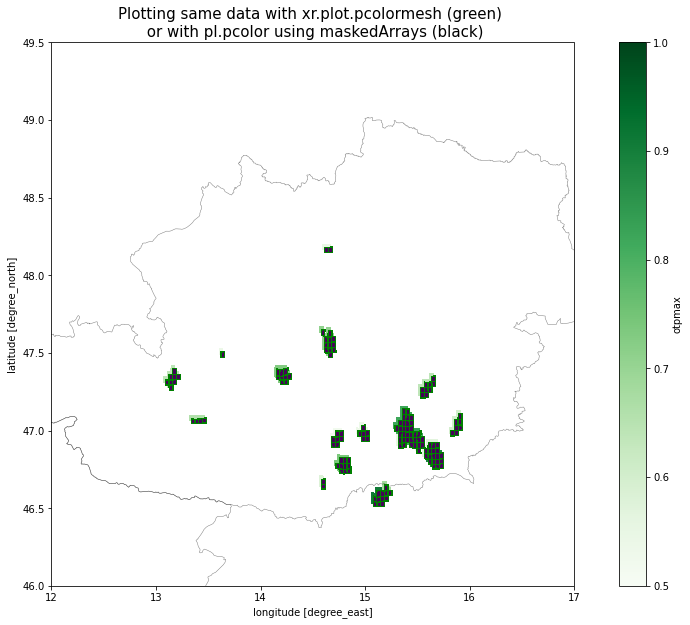

In [25]:
plt.subplots(figsize = (16,10))

ax = plt.axes(xlim=xlimG, ylim=ylimG, projection=ccrs.PlateCarree())

xr_OT.otpmax.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='Greens',vmin=0.5,vmax=1.0, #add_colorbar=False
)

cm=pl.pcolor(cpclon,cpclat,otpmax,color="green",vmin=0,vmax=100, zorder=3, alpha=1)

plt.xticks(np.arange(xlimG[0], xlimG[1]+1, 1))
plt.yticks(np.arange(ylimG[0], ylimG[1]+1, .5))

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

ax.set_title('Plotting same data with xr.plot.pcolormesh (green) \n or with pl.pcolor using maskedArrays (black)', 
             fontsize=15);

#plt.savefig('/home/ciccuz/phd/KIT/scripts/plots/xr_vs_maskArray.png', dpi=300, bbox_inches='tight')

**Zoom over specific grid cells**:

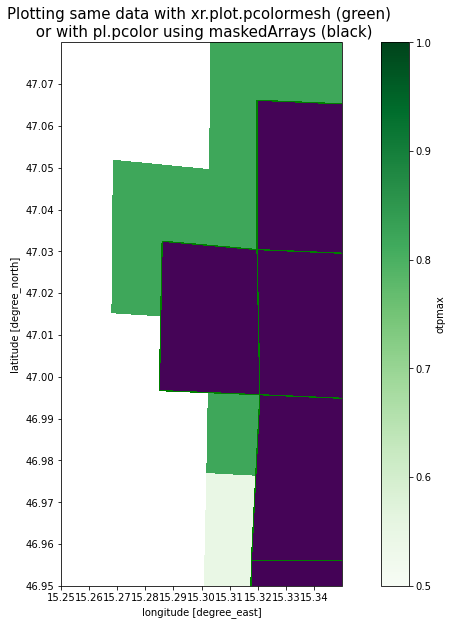

In [26]:
plt.subplots(figsize = (14,10))

xlimm = [15.25,15.35]
ylimm = [46.95,47.08]

ax = plt.axes(xlim=xlimm, ylim=ylimm, projection=ccrs.PlateCarree())

xr_OT.otpmax.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='Greens',vmin=0.5,vmax=1.0, #add_colorbar=False
)

cm=pl.pcolor(cpclon,cpclat,otpmax,color="green",vmin=0,vmax=100, zorder=3, alpha=1)

plt.xticks(np.arange(xlimm[0], xlimm[1], .01))
plt.yticks(np.arange(ylimm[0], ylimm[1], .01))

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

ax.set_title('Plotting same data with xr.plot.pcolormesh (green) \n or with pl.pcolor using maskedArrays (black)', 
             fontsize=15);

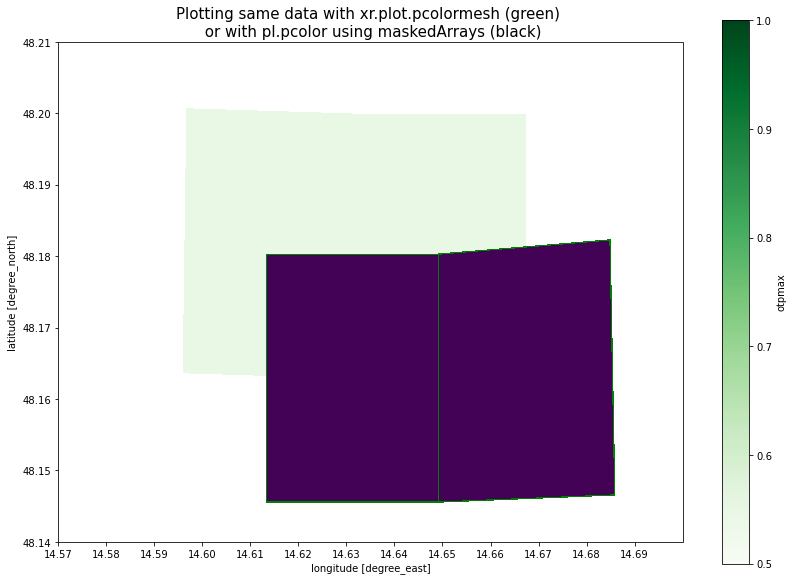

In [29]:
plt.subplots(figsize = (14,10))

xlimm = [14.57,14.7]
ylimm = [48.14,48.21]

ax = plt.axes(xlim=xlimm, ylim=ylimm, projection=ccrs.PlateCarree())

xr_OT.otpmax.plot.pcolormesh(
    ax=ax, transform=ccrs.PlateCarree(), x="lon", y="lat", cmap='Greens',vmin=0.5,vmax=1.0, #add_colorbar=False
)

cm=pl.pcolor(cpclon,cpclat,otpmax,color="green",vmin=0,vmax=100, zorder=3, alpha=1)

plt.xticks(np.arange(xlimm[0], xlimm[1], .01))
plt.yticks(np.arange(ylimm[0], ylimm[1], .01))

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

ax.set_title('Plotting same data with xr.plot.pcolormesh (green) \n or with pl.pcolor using maskedArrays (black)', 
             fontsize=15);

In the plot there are two boxes above the 48°N lat: a regular one on the left and a tilted one on the right. Checking on the non-null optmax dataframe (below) there are only two values with lat>48 -> This means that every OT detection is geolocalized with one point only (lat/lon) referring to the CENTER of the grid cell (and not by the left uppermost corner as it seemed before plotting with pcolor). Further a set of 4 points identifying a polygon (as the case for SPHERA gridded data) is not needed in this case!

### <span style="color:blue">  NICE!! this proves that with pcolor the coordinates refer to the upper-left corner of the grid cell while with pcolormesh to the center of the cell (as it should be!!!)</span>

### - Convert xarray dataset to pandas dataframe, set up geometry and build geodataframe:

In [27]:
#convert xarray dataset to pandas dataframe
df_xr_OT = xr_OT.to_dataframe()   #.unstack() #option to report the full matrix of lat/lon and ot values
df_xr_OT

lon        lat                  time  otpmax
xlon xlat                                                    
0    0      5.989858  48.848145  2016-08-29T13:00:00Z     NaN
     1      6.025572  48.848145  2016-08-29T13:00:00Z     NaN
     2      6.061286  48.848145  2016-08-29T13:00:00Z     NaN
     3      6.097000  48.848145  2016-08-29T13:00:00Z     NaN
     4      6.131714  48.848145  2016-08-29T13:00:00Z     NaN
...              ...        ...                   ...     ...
391  359   18.783285  34.939857  2016-08-29T13:00:00Z     NaN
     360   18.819000  34.939857  2016-08-29T13:00:00Z     NaN
     361   18.853716  34.939857  2016-08-29T13:00:00Z     NaN
     362   18.889431  34.939857  2016-08-29T13:00:00Z     NaN
     363   18.925144  34.939857  2016-08-29T13:00:00Z     NaN

[142688 rows x 4 columns]

In [28]:
#select non-null data with lat>48 (to check previous case)
df_xr_OT_noNULL = df_xr_OT[~df_xr_OT['otpmax'].isnull() == True]
df_noNULL_48 = df_xr_OT_noNULL[df_xr_OT_noNULL.lat>48]
df_noNULL_48

lon        lat                  time  otpmax
xlon xlat                                                    
18   243   14.613429  48.180283  2016-08-29T13:00:00Z    0.55
     244   14.649142  48.180283  2016-08-29T13:00:00Z    0.55

Write **geopandas dataframe** from pandas dataframe adding geometry formed by POINTS

In [29]:
gdf_xr_OT = gpd.GeoDataFrame(df_xr_OT, geometry=gpd.points_from_xy(df_xr_OT.lon, df_xr_OT.lat))
gdf_xr_OT

lon        lat                  time  otpmax  \
xlon xlat                                                       
0    0      5.989858  48.848145  2016-08-29T13:00:00Z     NaN   
     1      6.025572  48.848145  2016-08-29T13:00:00Z     NaN   
     2      6.061286  48.848145  2016-08-29T13:00:00Z     NaN   
     3      6.097000  48.848145  2016-08-29T13:00:00Z     NaN   
     4      6.131714  48.848145  2016-08-29T13:00:00Z     NaN   
...              ...        ...                   ...     ...   
391  359   18.783285  34.939857  2016-08-29T13:00:00Z     NaN   
     360   18.819000  34.939857  2016-08-29T13:00:00Z     NaN   
     361   18.853716  34.939857  2016-08-29T13:00:00Z     NaN   
     362   18.889431  34.939857  2016-08-29T13:00:00Z     NaN   
     363   18.925144  34.939857  2016-08-29T13:00:00Z     NaN   

                            geometry  
xlon xlat                             
0    0      POINT (5.98986 48.84814)  
     1      POINT (6.02557 48.84814)  
     2      POINT (6.06129 48.84814)  
     3      POINT (6.09700 48.84814)  
     4      POINT (6.13171 48.84814)  
...                              ...  
391  359   POINT (18.78329 34.93986)  
     360   POINT (18.81900 34.93986)  
     361   POINT (18.85372 34.93986)  
     362   POINT (18.88943 34.93986)  
     363   POINT (18.92514 34.93986)  

[142688 rows x 5 columns]

In [68]:
#extract only the subdataframe containing non null values of otpmax:
gdf_xr_OT_nn = gdf_xr_OT[~gdf_xr_OT['otpmax'].isnull() == True]
gdf_xr_OT_nn

lon        lat                  time  otpmax  \
xlon xlat                                                       
18   243   14.613429  48.180283  2016-08-29T13:00:00Z    0.58   
     244   14.649142  48.180283  2016-08-29T13:00:00Z    0.58   
33   242   14.579714  47.647575  2016-08-29T13:00:00Z    0.73   
     244   14.648143  47.642574  2016-08-29T13:00:00Z    0.70   
34   243   14.612430  47.606857  2016-08-29T13:00:00Z    0.70   
...              ...        ...                   ...     ...   
64   258   15.148144  46.540432  2016-08-29T13:00:00Z    0.92   
67   86     9.040286  46.434284  2016-08-29T13:00:00Z    0.55   
     87     9.077000  46.436283  2016-08-29T13:00:00Z    0.55   
     88     9.111715  46.436283  2016-08-29T13:00:00Z    0.55   
     89     9.148429  46.437283  2016-08-29T13:00:00Z    0.50   

                            geometry  
xlon xlat                             
18   243   POINT (14.61343 48.18028)  
     244   POINT (14.64914 48.18028)  
33   242   POINT (14.57971 47.64758)  
     244   POINT (14.64814 47.64257)  
34   243   POINT (14.61243 47.60686)  
...                              ...  
64   258   POINT (15.14814 46.54043)  
67   86     POINT (9.04029 46.43428)  
     87     POINT (9.07700 46.43628)  
     88     POINT (9.11172 46.43628)  
     89     POINT (9.14843 46.43728)  

[149 rows x 5 columns]

In [30]:
#extract only the subdataframe containing non null values of otpmax:
gdf_xr_OT_nn = gdf_xr_OT[~gdf_xr_OT['otpmax'].isnull() == True]
gdf_xr_OT_nn

lon        lat                  time  otpmax  \
xlon xlat                                                       
18   243   14.613429  48.180283  2016-08-29T13:00:00Z    0.55   
     244   14.649142  48.180283  2016-08-29T13:00:00Z    0.55   
33   242   14.579714  47.647575  2016-08-29T13:00:00Z    0.71   
     244   14.648143  47.642574  2016-08-29T13:00:00Z    0.71   
34   243   14.612430  47.606857  2016-08-29T13:00:00Z    0.71   
...              ...        ...                   ...     ...   
64   257   15.111428  46.538429  2016-08-29T13:00:00Z    0.91   
     258   15.148144  46.540432  2016-08-29T13:00:00Z    0.91   
67   86     9.040286  46.434284  2016-08-29T13:00:00Z    0.53   
     87     9.077000  46.436283  2016-08-29T13:00:00Z    0.53   
     88     9.111715  46.436283  2016-08-29T13:00:00Z    0.53   

                            geometry  
xlon xlat                             
18   243   POINT (14.61343 48.18028)  
     244   POINT (14.64914 48.18028)  
33   242   POINT (14.57971 47.64758)  
     244   POINT (14.64814 47.64257)  
34   243   POINT (14.61243 47.60686)  
...                              ...  
64   257   POINT (15.11143 46.53843)  
     258   POINT (15.14814 46.54043)  
67   86     POINT (9.04029 46.43428)  
     87     POINT (9.07700 46.43628)  
     88     POINT (9.11172 46.43628)  

[145 rows x 5 columns]

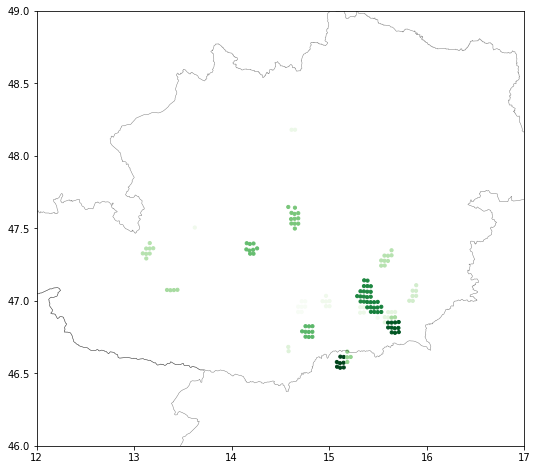

In [31]:
ax = gdf_xr_OT_nn[['otpmax','geometry']].plot(markersize=10, figsize=(12, 8), column='otpmax', cmap='Greens')

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)
#plt.autoscale(False)

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)


### <span style="color:blue">  NEW APPROACH: instead of building boxes around OT detections, select SPHERA grid around them (see below and skip this part) </span>

Now: I want to build a 0.55° (approx 60km) grid cell around every lon/lat couples indicating the centers of OT detections grids, and I want as output the four points indicating the corners of the 0.55° grid cells (just add 0.55°/2 in every direction from the center?):

Some (maybe useful) suggestions:

- https://gis.stackexchange.com/questions/396533/how-to-calculate-the-corner-points-of-a-grid-if-centre-points-are-know
- https://github.com/pangeo-data/pangeo/issues/356
- https://gis.stackexchange.com/questions/244677/performing-spatial-join-match-points-from-dataframe-to-polygons-using-python
- https://github.com/mthh/gpd_lite_toolbox
- https://james-brennan.github.io/posts/fast_gridding_geopandas/

#### ( - Build 0.55° boxes around each OT detection)

(by setting up a second polygon geometry starting from the original point geometry of the geodataframe)

In [32]:
import shapely

In [33]:
#define dimension of the cell: 0.55° approx 60km boxes
cell_size = 0.55
# create the cells in a loop
grid_cells = []

#define every cell from the coordinates their centers represented by each point (x,y) and from the cell_size
for (x,y) in zip(gdf_xr_OT_nn.lon, gdf_xr_OT_nn.lat):
    
    #print((x,y), (x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2) )
    grid_cells.append(shapely.geometry.box(x-cell_size/2, y-cell_size/2, x+cell_size/2, y+cell_size/2))

cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'])
gdf_xr_OT_nn['geometry_055box'] = cell.values

In [34]:
gdf_xr_OT_nn

lon        lat                  time  otpmax  \
xlon xlat                                                       
18   243   14.613429  48.180283  2016-08-29T13:00:00Z    0.55   
     244   14.649142  48.180283  2016-08-29T13:00:00Z    0.55   
33   242   14.579714  47.647575  2016-08-29T13:00:00Z    0.71   
     244   14.648143  47.642574  2016-08-29T13:00:00Z    0.71   
34   243   14.612430  47.606857  2016-08-29T13:00:00Z    0.71   
...              ...        ...                   ...     ...   
64   257   15.111428  46.538429  2016-08-29T13:00:00Z    0.91   
     258   15.148144  46.540432  2016-08-29T13:00:00Z    0.91   
67   86     9.040286  46.434284  2016-08-29T13:00:00Z    0.53   
     87     9.077000  46.436283  2016-08-29T13:00:00Z    0.53   
     88     9.111715  46.436283  2016-08-29T13:00:00Z    0.53   

                            geometry  \
xlon xlat                              
18   243   POINT (14.61343 48.18028)   
     244   POINT (14.64914 48.18028)   
33   242   POINT (14.57971 47.64758)   
     244   POINT (14.64814 47.64257)   
34   243   POINT (14.61243 47.60686)   
...                              ...   
64   257   POINT (15.11143 46.53843)   
     258   POINT (15.14814 46.54043)   
67   86     POINT (9.04029 46.43428)   
     87     POINT (9.07700 46.43628)   
     88     POINT (9.11172 46.43628)   

                                             geometry_055box  
xlon xlat                                                     
18   243   POLYGON ((14.88842906951904 47.90528259277344,...  
     244   POLYGON ((14.92414226531982 47.90528259277344,...  
33   242   POLYGON ((14.85471382141113 47.37257537841797,...  
     244   POLYGON ((14.92314281463623 47.36757431030274,...  
34   243   POLYGON ((14.88742961883545 47.33185729980469,...  
...                                                      ...  
64   257   POLYGON ((15.38642826080322 46.26342926025391,...  
     258   POLYGON ((15.42314376831055 46.26543197631836,...  
67   86    POLYGON ((9.31528606414795 46.15928421020508, ...  
     87    POLYGON ((9.351999664306641 46.16128311157227,...  
     88    POLYGON ((9.386715316772461 46.16128311157227,...  

[145 rows x 6 columns]

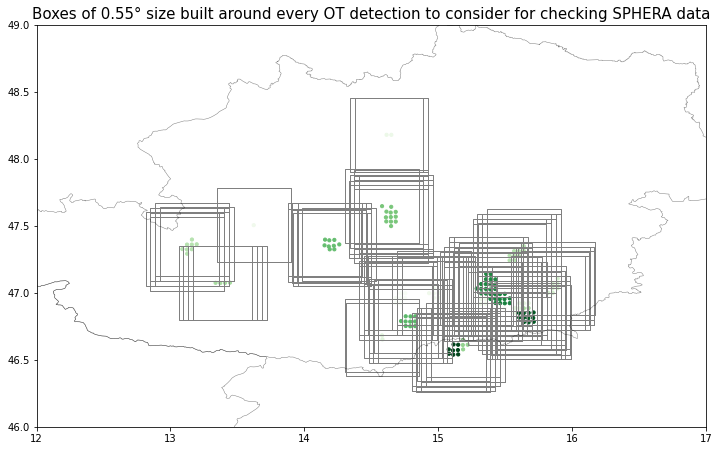

In [45]:
otp_gdf_xr_OT_nn = gdf_xr_OT_nn.drop(columns=['lat', 'lon', 'time', 'geometry_055box'])

ax = otp_gdf_xr_OT_nn.plot(markersize=10, figsize=(12, 8), column='otpmax', cmap='Greens')

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)
#plt.autoscale(False)

sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)

cell.plot(ax=ax, facecolor="none", edgecolor='grey');
plt.title('Boxes of 0.55° size built around every OT detection to consider for checking SPHERA data', fontsize=15);

#plt.savefig('/home/ciccuz/phd/KIT/scripts/plots/OT_filter_construction/055.png', 
#            dpi=300, bbox_inches='tight')

#### ( - Extract SPHERA gridded data contained in every box considered:)

Consider for example the daily max of CAPE (completely random! just to test method)

In [36]:
sp_par = "CAPE_MU"
col_num = 6
cbar_ext = 'max'
un_meas = '[J/kg]'

In [40]:
dtime = datetime.datetime.strptime('2016-08-29','%Y-%m-%d')

In [42]:
df_sp = HF.HF_reanProxies_read(dtime)
df_sp.box_id = df_sp.box_id - 1 # <---- !!!!!!
df_sp_dayMax = df_sp.groupby(['box_id'], as_index=False).max().drop(columns=['datetime'])

#select hour of the day corresponding to OT timing:
df_sp_Hsel = df_sp[df_sp['datetime'].dt.hour == 
                   int(pd.to_datetime(gdf_xr_OT_nn.time[:1]).reset_index(drop=True).dt.hour)].reset_index(drop=True)
#df_sp_Hsel = df_sp_dayMax

#e.g. SPHERA geodataframe using geometry from grid shapefile:
sf_sp = gpd.read_file(fold + "data/lampinet/mask/grid_10_49N.shp", encoding='latin-1')

#build geodataframe: condition on geometry because box_id != index (the upper right corner of SPHERA domain is not
#covered due to grid rotation, so some cells must be excluded otherwise data are displaced in the wrong boxes!)
gdf_sp_sel = gpd.GeoDataFrame(df_sp_Hsel,    #[["box_id","CAPE_MU"]] 
                              geometry=sf_sp.loc[sf_sp.index[list(df_sp_Hsel['box_id'])]].reset_index(drop=True)['geometry'])

color_ton, bins, colors = HF.HF_calc_color(gdf_sp_sel["CAPE_MU"], color=6)
gdf_sp_sel['color'] = color_ton

gdf_sp_sel

,datetime,box_id,%VV700,AvvGeop500,Kindex,LI,DLS,H0,CAPE_MU,CAPE_ML,geometry,color
0,2016-08-29 13:00:00,-1,45.000000,23.749231,24.239956,1.225819,9.686988,4424.53760,109.906250,17.415625,"POLYGON ((18.90000 48.90000, 18.90000 49.00000...",#FFFFB5
1,2016-08-29 13:00:00,0,56.521740,32.733170,17.161859,3.356663,7.302716,4428.73926,117.304344,32.750000,"POLYGON ((6.00000 35.00000, 6.00000 35.10000, ...",#FFFFB5
2,2016-08-29 13:00:00,1,22.727272,-20.210056,15.843295,3.459939,5.481956,4507.50586,103.170456,21.661932,"POLYGON ((6.10000 35.00000, 6.10000 35.10000, ...",#FFFFB5
3,2016-08-29 13:00:00,2,45.000000,-101.622681,15.408972,3.224183,7.500867,4439.34375,82.431252,16.959375,"POLYGON ((6.20000 35.00000, 6.20000 35.10000, ...",#FFFFB5
4,2016-08-29 13:00:00,3,50.000000,-86.428688,18.279592,2.999257,8.995049,4417.59375,75.331253,14.696875,"POLYGON ((6.30000 35.00000, 6.30000 35.10000, ...",#FFFFB5
...,...,...,...,...,...,...,...,...,...,...,...,...
18110,2016-08-29 13:00:00,18144,0.000000,0.000000,29.621420,-0.777720,11.100116,3599.08325,260.500000,152.145828,"POLYGON ((13.40000 48.90000, 13.40000 49.00000...",#FFFFB5
18111,2016-08-29 13:00:00,18145,0.000000,0.000000,30.287842,-0.702037,10.570650,3578.65625,248.187500,142.156250,"POLYGON ((13.50000 48.90000, 13.50000 49.00000...",#FFFFB5
18112,2016-08-29 13:00:00,18146,0.000000,0.000000,30.937317,-0.630422,10.060265,3572.83325,234.083328,134.479172,"POLYGON ((13.60000 48.90000, 13.60000 49.00000...",#FFFFB5
18113,2016-08-29 13:00:00,18147,0.000000,0.000000,31.262329,-0.574921,9.761900,3571.50000,224.916672,127.083336,"POLYGON ((13.70000 48.90000, 13.70000 49.00000...",#FFFFB5


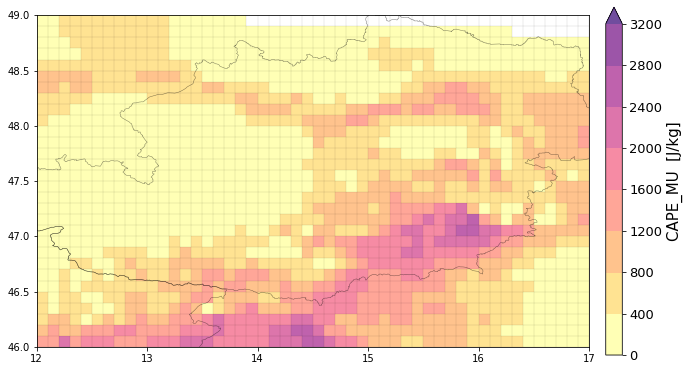

In [43]:
fig, ax = plt.subplots(figsize = (12,8))

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)

#grid shapefile
sf_sp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.1, linestyle='--', zorder=2)

#geographic shapefiles
sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #ita shapefile
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #other shapefile


#plot geodataframe of SPHERA data with color_ton as colorcoding
gdf_sp_sel[['CAPE_MU','geometry']].plot(ax=ax, color=gdf_sp_sel['color']) 

#add colorbar
cmap_sp_par = matplotlib.colors.ListedColormap(sns.color_palette(colors).as_hex())
norm = matplotlib.colors.BoundaryNorm(bins, cmap_sp_par.N, extend=cbar_ext)

img = plt.imshow([bins], cmap=cmap_sp_par, norm=norm)
img.set_visible(False)

cb_sp_par=plt.colorbar(orientation='vertical', spacing='proportional', norm=norm,  pad=0.025, shrink=0.8);
cb_sp_par.ax.set_yticklabels(bins, fontsize=13)
cb_sp_par.ax.set_ylabel(f'{sp_par}  {un_meas}', fontsize=15);

Now we need to select from the full SPHERA geodataframe the subset contained in a 0.55° box defined as:

In [42]:
#For selecting data around a defined polygon:
#box around which check for SPHERA data
poly0 = gdf_xr_OT_nn['geometry_055box'].reset_index(drop=True)[0]

#define subset of SPHERA data contained in the selected box:
subset0 = gdf_sp_sel[gdf_sp_sel.geometry.within(poly0) == True]

#select corresponding box and OT point centered over the box:
cell0 = cell[cell.geometry == poly0]

OTpoint0 = otp_gdf_xr_OT_nn[int(cell0.index.values):int(cell0.index.values)+1]

Try to plot few examples together:

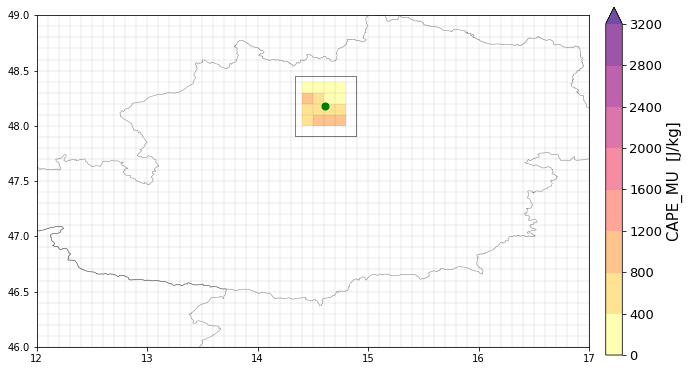

In [43]:
fig, ax = plt.subplots(figsize = (12,8))

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)

#grid shapefile
sf_sp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.1, linestyle='--', zorder=2)

#geographic shapefiles
sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #ita shapefile
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #other shapefile


#plot geodataframe of SPHERA data with color_ton as colorcoding
subset0[['CAPE_MU','geometry']].plot(ax=ax, color=subset0['color'])

#add colorbar
cmap_sp_par = matplotlib.colors.ListedColormap(sns.color_palette(colors).as_hex())
norm = matplotlib.colors.BoundaryNorm(bins, cmap_sp_par.N, extend=cbar_ext)

img = plt.imshow([bins], cmap=cmap_sp_par, norm=norm)
img.set_visible(False)

cb_sp_par=plt.colorbar(orientation='vertical', spacing='proportional', norm=norm,  pad=0.025, shrink=0.8);
cb_sp_par.ax.set_yticklabels(bins, fontsize=13)
cb_sp_par.ax.set_ylabel(f'{sp_par}  {un_meas}', fontsize=15);


#plot box
cell0.plot(ax=ax, facecolor="none", edgecolor='grey');

#plot OT point data
OTpoint0.plot(ax=ax, markersize=50, column='otpmax', color='green');

In [44]:
#For selecting data around a defined polygon:
#box around which check for SPHERA data
poly1 = gdf_xr_OT_nn['geometry_055box'].reset_index(drop=True)[25]
poly2 = gdf_xr_OT_nn['geometry_055box'].reset_index(drop=True)[50]
poly3 = gdf_xr_OT_nn['geometry_055box'].reset_index(drop=True)[75]
poly4 = gdf_xr_OT_nn['geometry_055box'].reset_index(drop=True)[100]
poly5 = gdf_xr_OT_nn['geometry_055box'].reset_index(drop=True)[130]

#define subset of SPHERA data contained in the selected box:
subset1 = gdf_sp_sel[gdf_sp_sel.geometry.within(poly1) == True]
subset2 = gdf_sp_sel[gdf_sp_sel.geometry.within(poly2) == True]
subset3 = gdf_sp_sel[gdf_sp_sel.geometry.within(poly3) == True]
subset4 = gdf_sp_sel[gdf_sp_sel.geometry.within(poly4) == True]
subset5 = gdf_sp_sel[gdf_sp_sel.geometry.within(poly5) == True]

In [45]:
#select corresponding boxes and OT point centered over the boxes:
cell1 = cell[cell.geometry == poly1]
cell2 = cell[cell.geometry == poly2]
cell3 = cell[cell.geometry == poly3]
cell4 = cell[cell.geometry == poly4]
cell5 = cell[cell.geometry == poly5]

OTpoint1 = otp_gdf_xr_OT_nn[int(cell1.index.values):int(cell1.index.values)+1]
OTpoint2 = otp_gdf_xr_OT_nn[int(cell2.index.values):int(cell2.index.values)+1]
OTpoint3 = otp_gdf_xr_OT_nn[int(cell3.index.values):int(cell3.index.values)+1]
OTpoint4 = otp_gdf_xr_OT_nn[int(cell4.index.values):int(cell4.index.values)+1]
OTpoint5 = otp_gdf_xr_OT_nn[int(cell5.index.values):int(cell5.index.values)+1]

<AxesSubplot:>

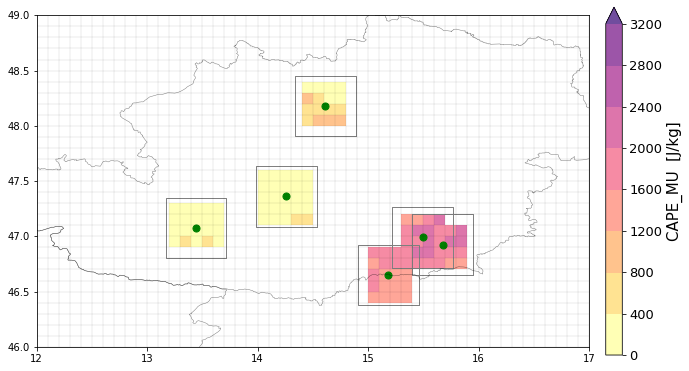

In [46]:
fig, ax = plt.subplots(figsize = (12,8))

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)

#grid shapefile
sf_sp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.1, linestyle='--', zorder=2)

#geographic shapefiles
sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #ita shapefile
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #other shapefile


#plot geodataframe of SPHERA data with color_ton as colorcoding
subset0[['CAPE_MU','geometry']].plot(ax=ax, color=subset0['color'])
subset1[['CAPE_MU','geometry']].plot(ax=ax, color=subset1['color'])
subset2[['CAPE_MU','geometry']].plot(ax=ax, color=subset2['color'])
subset3[['CAPE_MU','geometry']].plot(ax=ax, color=subset3['color'])
subset4[['CAPE_MU','geometry']].plot(ax=ax, color=subset4['color'])
subset5[['CAPE_MU','geometry']].plot(ax=ax, color=subset5['color'])

#add colorbar
cmap_sp_par = matplotlib.colors.ListedColormap(sns.color_palette(colors).as_hex())
norm = matplotlib.colors.BoundaryNorm(bins, cmap_sp_par.N, extend=cbar_ext)

img = plt.imshow([bins], cmap=cmap_sp_par, norm=norm)
img.set_visible(False)

cb_sp_par=plt.colorbar(orientation='vertical', spacing='proportional', norm=norm,  pad=0.025, shrink=0.8);
cb_sp_par.ax.set_yticklabels(bins, fontsize=13)
cb_sp_par.ax.set_ylabel(f'{sp_par}  {un_meas}', fontsize=15);


#plot box
cell0.plot(ax=ax, facecolor="none", edgecolor='grey');
cell1.plot(ax=ax, facecolor="none", edgecolor='grey');
cell2.plot(ax=ax, facecolor="none", edgecolor='grey');
cell3.plot(ax=ax, facecolor="none", edgecolor='grey');
cell4.plot(ax=ax, facecolor="none", edgecolor='grey');
cell5.plot(ax=ax, facecolor="none", edgecolor='grey');

#plot OT point data
OTpoint0.plot(ax=ax, markersize=50, column='otpmax', color='green')
OTpoint1.plot(ax=ax, markersize=50,  column='otpmax', color='green')
OTpoint2.plot(ax=ax, markersize=50,  column='otpmax', color='green')
OTpoint3.plot(ax=ax, markersize=50,  column='otpmax', color='green')
OTpoint4.plot(ax=ax, markersize=50,  column='otpmax', color='green')
OTpoint5.plot(ax=ax, markersize=50,  column='otpmax', color='green')

#plt.savefig('/home/ciccuz/phd/KIT/scripts/plots/OT_filter_construction/spatMatch_sphera_OT_055boxes.png', 
#            dpi=300, bbox_inches='tight');

### -  <span style="color:blue">  New approach: </span> identify SPHERA grid containing OT point and build a square around it

In [47]:
# list of SPHERA cells containing the OT detections:
S_OTcells = []

#loop to identify which SPHERA grid contains each OT point
for point in otp_gdf_xr_OT_nn.reset_index(drop=True).geometry:
    
    for s_cell in gdf_sp_sel.geometry:
         
        if point.within(s_cell):
            
            #condition for not repeating the same cell more than once:
            if not any(p.equals(s_cell) for p in S_OTcells):
            
                S_OTcells.append(s_cell)
      

#select subset of SPHERA data related to the identified S_cells:
gdf_sp_sel_OTcells = gdf_sp_sel[['box_id','CAPE_MU','geometry','color']][gdf_sp_sel.geometry.isin(S_OTcells)]

In [48]:
gdf_sp_sel_OTcells

,box_id,CAPE_MU,geometry,color
14850,14850,423.316681,"POLYGON ((9.00000 46.40000, 9.00000 46.50000, ...",#FFE392
14851,14851,295.343750,"POLYGON ((9.10000 46.40000, 9.10000 46.50000, ...",#FFFFB5
15040,15040,1630.333370,"POLYGON ((15.00000 46.50000, 15.00000 46.60000...",#F68BA4
15041,15041,1357.604130,"POLYGON ((15.10000 46.50000, 15.10000 46.60000...",#FFA698
15165,15165,662.056274,"POLYGON ((14.50000 46.60000, 14.50000 46.70000...",#FFE392
15171,15171,1490.966670,"POLYGON ((15.10000 46.60000, 15.10000 46.70000...",#FFA698
15172,15172,1448.593750,"POLYGON ((15.20000 46.60000, 15.20000 46.70000...",#FFA698
15297,15297,334.166656,"POLYGON ((14.70000 46.70000, 14.70000 46.80000...",#FFFFB5
15298,15298,696.825012,"POLYGON ((14.80000 46.70000, 14.80000 46.80000...",#FFE392
15306,15306,1769.765620,"POLYGON ((15.60000 46.70000, 15.60000 46.80000...",#F68BA4


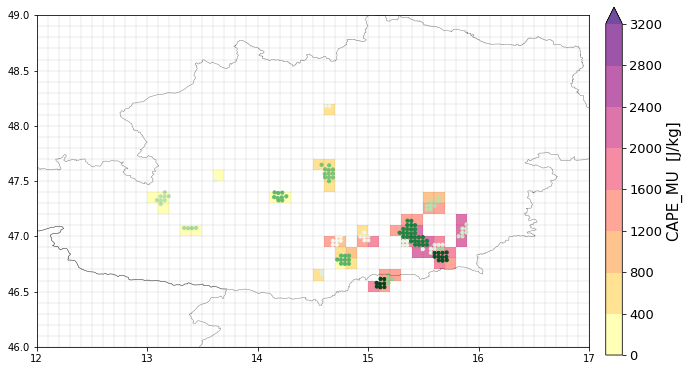

In [49]:
fig, ax = plt.subplots(figsize = (12,8))

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)

#grid shapefile
sf_sp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.1, linestyle='--', zorder=2)

#geographic shapefiles
sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #ita shapefile
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #other shapefile


#plot geodataframe of SPHERA data with color_ton as colorcoding
gdf_sp_sel_OTcells.plot(ax=ax, color=gdf_sp_sel_OTcells['color'])

otp_gdf_xr_OT_nn.plot(ax=ax, markersize=10, figsize=(12, 8), column='otpmax', cmap='Greens')

#add colorbar
cmap_sp_par = matplotlib.colors.ListedColormap(sns.color_palette(colors).as_hex())
norm = matplotlib.colors.BoundaryNorm(bins, cmap_sp_par.N, extend=cbar_ext)

img = plt.imshow([bins], cmap=cmap_sp_par, norm=norm)
img.set_visible(False)

cb_sp_par=plt.colorbar(orientation='vertical', spacing='proportional', norm=norm,  pad=0.025, shrink=0.8);
cb_sp_par.ax.set_yticklabels(bins, fontsize=13)
cb_sp_par.ax.set_ylabel(f'{sp_par}  {un_meas}', fontsize=15);

In [50]:
#Select for every cell the spatial neighbourhood of 7x7=49 grid cells around it (res. of approx 0.63° 70km):

#identify cell
cel1 = S_OTcells[0]
sp_cel1 = gdf_sp_sel[gdf_sp_sel.geometry ==  cel1]

#select 70km-nearest neighbourhood (nn) around the cell (the 48+1(itself) grid  cells having the smallest dist.):
nn_ind1 = gdf_sp_sel.geometry.distance(cel1).sort_values()[:49].index
nn_sp_cel1 = gdf_sp_sel.loc[nn_ind1]

In [51]:
#some more trials:
cel2 = S_OTcells[30]
sp_cel2 = gdf_sp_sel[gdf_sp_sel.geometry ==  cel2]
nn_ind2 = gdf_sp_sel.geometry.distance(cel2).sort_values()[:49].index
nn_sp_cel2 = gdf_sp_sel.loc[nn_ind2]

cel3 = S_OTcells[45]
sp_cel3 = gdf_sp_sel[gdf_sp_sel.geometry ==  cel3]
nn_ind3 = gdf_sp_sel.geometry.distance(cel3).sort_values()[:49].index
nn_sp_cel3 = gdf_sp_sel.loc[nn_ind3]

cel4 = S_OTcells[23]
sp_cel4 = gdf_sp_sel[gdf_sp_sel.geometry ==  cel4]
nn_ind4 = gdf_sp_sel.geometry.distance(cel4).sort_values()[:49].index
nn_sp_cel4 = gdf_sp_sel.loc[nn_ind4]

cel5 = S_OTcells[6]
sp_cel5 = gdf_sp_sel[gdf_sp_sel.geometry ==  cel5]
nn_ind5 = gdf_sp_sel.geometry.distance(cel5).sort_values()[:49].index
nn_sp_cel5 = gdf_sp_sel.loc[nn_ind5]

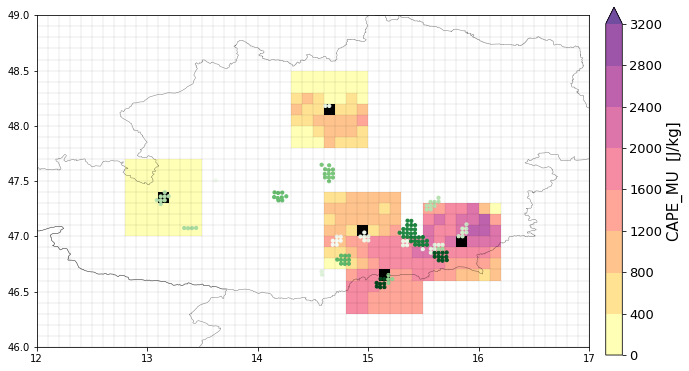

In [52]:
fig, ax = plt.subplots(figsize = (12,8))

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)

#grid shapefile
sf_sp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.1, linestyle='--', zorder=2)

#geographic shapefiles
sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #ita shapefile
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #other shapefile

#plot geodataframe of SPHERA data with color_ton as colorcoding

nn_sp_cel1.plot(ax=ax, color=nn_sp_cel1['color'])
sp_cel1.plot(ax=ax, color='black')

nn_sp_cel2.plot(ax=ax, color=nn_sp_cel2['color'])
sp_cel2.plot(ax=ax, color='black')

nn_sp_cel3.plot(ax=ax, color=nn_sp_cel3['color'])
sp_cel3.plot(ax=ax, color='black')

nn_sp_cel4.plot(ax=ax, color=nn_sp_cel4['color'])
sp_cel4.plot(ax=ax, color='black')

nn_sp_cel5.plot(ax=ax, color=nn_sp_cel5['color'])
sp_cel5.plot(ax=ax, color='black')

otp_gdf_xr_OT_nn.plot(ax=ax, markersize=10, figsize=(12, 8), column='otpmax', cmap='Greens')

#add colorbar
cmap_sp_par = matplotlib.colors.ListedColormap(sns.color_palette(colors).as_hex())
norm = matplotlib.colors.BoundaryNorm(bins, cmap_sp_par.N, extend=cbar_ext)

img = plt.imshow([bins], cmap=cmap_sp_par, norm=norm)
img.set_visible(False)

cb_sp_par=plt.colorbar(orientation='vertical', spacing='proportional', norm=norm,  pad=0.025, shrink=0.8);
cb_sp_par.ax.set_yticklabels(bins, fontsize=13)
cb_sp_par.ax.set_ylabel(f'{sp_par}  {un_meas}', fontsize=15);

#plt.savefig('/home/ciccuz/phd/KIT/scripts/plots/OT_filter_construction/spatMatch_sphera_OT_Sneighbourhood.png', 
#            dpi=300, bbox_inches='tight');

In [53]:
#Loop to apply it to every cell containing at least 1 OT detection:

nn_sp_OTcells = dict()

for cel in S_OTcells:
    #identify cell
    sp_cel = gdf_sp_sel[gdf_sp_sel.geometry ==  cel]
    
    #select 70km-nearest neighbourhood (nn) around the cell (the 48+1(itself) grid  cells having the smallest dist.):
    nn_ind = gdf_sp_sel.geometry.distance(cel).sort_values()[:49].index
    nn_sp_OTcells[int(sp_cel.index.values)] = gdf_sp_sel.loc[nn_ind]

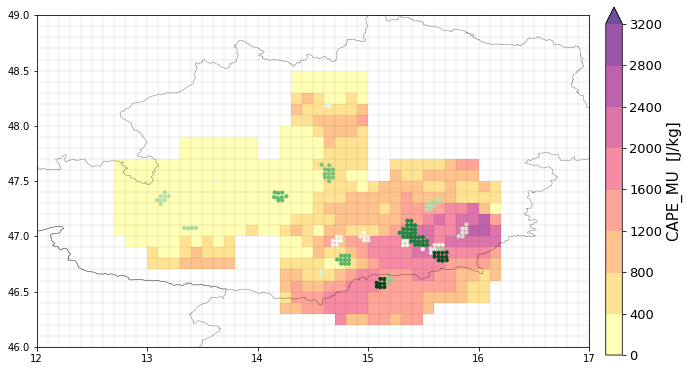

In [56]:
fig, ax = plt.subplots(figsize = (12,8))

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)

#grid shapefile
sf_sp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.1, linestyle='--', zorder=2)

#geographic shapefiles
sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #ita shapefile
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #other shapefile

#plot geodataframe of SPHERA data with color_ton as colorcoding

for S_OTcell in nn_sp_OTcells.keys():
    nn_sp_OTcells[S_OTcell].plot(ax=ax, color=nn_sp_OTcells[S_OTcell]['color'])

otp_gdf_xr_OT_nn.plot(ax=ax, markersize=10, figsize=(12, 8), column='otpmax', cmap='Greens')

#add colorbar
cmap_sp_par = matplotlib.colors.ListedColormap(sns.color_palette(colors).as_hex())
norm = matplotlib.colors.BoundaryNorm(bins, cmap_sp_par.N, extend=cbar_ext)

img = plt.imshow([bins], cmap=cmap_sp_par, norm=norm)
img.set_visible(False)

cb_sp_par=plt.colorbar(orientation='vertical', spacing='proportional', norm=norm,  pad=0.025, shrink=0.8);
cb_sp_par.ax.set_yticklabels(bins, fontsize=13)
cb_sp_par.ax.set_ylabel(f'{sp_par}  {un_meas}', fontsize=15);

#plt.savefig('/home/ciccuz/phd/KIT/scripts/plots/OT_filter_construction/spatMatch_sphera_OT_Sneighbourhood_all.png', 
#            dpi=300, bbox_inches='tight');

### - Temporal window: consider SPHERA max/min parameters in the 4hours before OT occurrence before spatial matching:

In [1]:
#find timing of OT occurrence
OT_hour = pd.to_datetime(gdf_xr_OT_nn.time[:1]).reset_index(drop=True).dt.hour

NameError: name 'pd' is not defined

In [58]:
#select the last 4 hours from SPHERA daily dataset
df_sp_4OTh = df_sp.loc[(df_sp.datetime.dt.hour > (int(OT_hour) - 4)) & 
                       (df_sp.datetime.dt.hour <= int(OT_hour))].reset_index(drop=True)

In [59]:
#build sphera dataframe containing temporal aggregation over the last 4 hours (max/min depending on param):
tempAg_sp_4OTh = gpd.GeoDataFrame(columns=['datetime_agg','box_id','%VV700','Kindex','LI','DLS','H0',
                                       'CAPE_MU','CAPE_ML','geometry'])
tempAg_sp_4OTh['box_id'] = df_sp_4OTh.groupby(['box_id'], as_index=False).max()['box_id']
tempAg_sp_4OTh['datetime_agg'][:] = df_sp_4OTh["datetime"].iloc[-1]
tempAg_sp_4OTh['%VV700'] = df_sp_4OTh.groupby(['box_id'], as_index=False).max()['%VV700']
tempAg_sp_4OTh['Kindex'] = df_sp_4OTh.groupby(['box_id'], as_index=False).max()['Kindex']
tempAg_sp_4OTh['LI'] = df_sp_4OTh.groupby(['box_id'], as_index=False).min()['LI']
tempAg_sp_4OTh['DLS'] = df_sp_4OTh.groupby(['box_id'], as_index=False).max()['DLS']
tempAg_sp_4OTh['H0'] = df_sp_4OTh.groupby(['box_id'], as_index=False).min()['H0']
tempAg_sp_4OTh['CAPE_MU'] = df_sp_4OTh.groupby(['box_id'], as_index=False).max()['CAPE_MU']
tempAg_sp_4OTh['CAPE_ML'] = df_sp_4OTh.groupby(['box_id'], as_index=False).max()['CAPE_ML']
tempAg_sp_4OTh['geometry'] = sf_sp.loc[sf_sp.index[list(tempAg_sp_4OTh['box_id'])]].reset_index(drop=True)['geometry']

In [60]:
color_ton_CAPE_MU, bins_CAPE_MU, colors_CAPE_MU = HF.HF_calc_color(tempAg_sp_4OTh["CAPE_MU"], color=6)

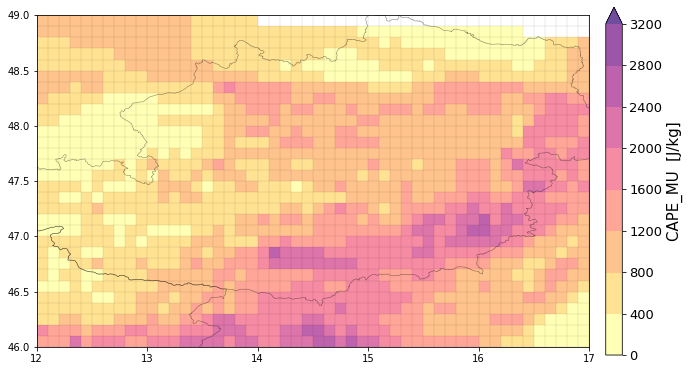

In [61]:
fig, ax = plt.subplots(figsize = (12,8))

ax.set_ylim(ylimG)
ax.set_xlim(xlimG)

#grid shapefile
sf_sp.plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.1, linestyle='--', zorder=2)

#geographic shapefiles
sf_geo[0].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #ita shapefile
if len(sf_geo) > 1:
    sf_geo[1].plot(ax=ax, alpha = 0.5, facecolor = 'none', lw = 0.5, zorder=2)  #other shapefile


#plot geodataframe of SPHERA data with color_ton as colorcoding
tempAg_sp_4OTh[['CAPE_MU','geometry']].plot(ax=ax, color=color_ton_CAPE_MU)

#add colorbar
cmap_sp_par = matplotlib.colors.ListedColormap(sns.color_palette(colors_CAPE_MU).as_hex())
norm = matplotlib.colors.BoundaryNorm(bins, cmap_sp_par.N, extend=cbar_ext)

img = plt.imshow([bins_CAPE_MU], cmap=cmap_sp_par, norm=norm)
img.set_visible(False)

cb_sp_par=plt.colorbar(orientation='vertical', spacing='proportional', norm=norm,  pad=0.025, shrink=0.8);
cb_sp_par.ax.set_yticklabels(bins, fontsize=13)
cb_sp_par.ax.set_ylabel(f'{sp_par}  {un_meas}', fontsize=15);

### Follow Heinz Jurgen procedure: (problem is that he had also era5 data in netcdf)

<span style="color:red"> 
    
- "OT data are preprocessed and boxed to era domain" (how???is this true?)
    
- Also I found: reanalysis (era-interim) data are extracted as 16x16 grid points (1200kmx1200km) box surrounding each OT report. How to do that??
    
- For example: also to plot the tot number of OT detected in a certain temporal window of some years, how was he able to take all the OT together, count them and plot in a map (with some smoothing applied or upscaling I guess??)??
</span>

### - Collect all OT detections of the set of events and build a unique dataset considering all days together:
aggregating every hour

###### - Events set:
Upload all OT events dataset considering the whole day and for the whole SPHERA domain (hh and lon/lat params static)

In [164]:
#dictionary to store metadata of events:
ev = {}

#dataframe to combine data of all events
ev_df = pd.DataFrame(columns=['day','year_u','mon_u','day_u',])

#CONDITION ON HOURS: consider from 0 to 24 to consider the whole set of OT detections from 00 to 23:45 UTC
hhmin=0
hhmax=24

In [165]:
"""
7 April 2016 (Condove - Torino)
"""
day=2016098; year_u=2016; mon_u=4; day_u=7; 
ev[0] = [day,year_u,mon_u,day_u]

"""
8 April 2016 (Condove - Torino)
"""
day=2016099; year_u=2016; mon_u=4; day_u=8; 
ev[1] = [day,year_u,mon_u,day_u]

"""
18 June 2016 (Asiago - Veneto)
"""
day=2016170; year_u=2016; mon_u=6; day_u=18; 
ev[2] = [day,year_u,mon_u,day_u]

"""
24 June 2016 (Dettingen - S Germany)
"""
day=2016176; year_u=2016; mon_u=6; day_u=24; 
ev[3] = [day,year_u,mon_u,day_u]

"""
5 August 2016 (Mondolfo (PU) - Marche)
"""
day=2016218; year_u=2016; mon_u=8; day_u=5; 
ev[4] = [day,year_u,mon_u,day_u]

"""
16 August 2016 (Albenga - Savona)
"""
day=2016229; year_u=2016; mon_u=8; day_u=16; 
ev[5] = [day,year_u,mon_u,day_u]

"""
29 August 2016 (Torino + Graz)
"""
day=2016242; year_u=2016; mon_u=8; day_u=29;
ev[6] = [day,year_u,mon_u,day_u]

"""
15 October 2016 (Casalbordino (Chieti) - Abruzzo)
"""
day=2016289; year_u=2016; mon_u=10; day_u=15;
ev[7] = [day,year_u,mon_u,day_u]

"""
4 May 2017 (Treviso - Veneto)
"""
day=2017124; year_u=2017; mon_u=5; day_u=4; 
ev[8]= [day,year_u,mon_u,day_u]

"""
14 May 2017 (Veneto - Nord-est Italy)
"""
day=2017134; year_u=2017; mon_u=5; day_u=14; 
ev[9] = [day,year_u,mon_u,day_u]

"""
25 June 2017 (Nord-est Italy)
"""
day=2017176; year_u=2017; mon_u=6; day_u=25; 
ev[10] = [day,year_u,mon_u,day_u]

"""
27 June 2017 (Asti)
"""
day=2017178; year_u=2017; mon_u=6; day_u=27;
ev[11] = [day,year_u,mon_u,day_u]

"""
28 June 2017 (Nord Italy)
"""
day=2017179; year_u=2017; mon_u=6; day_u=28; 
ev[12] = [day,year_u,mon_u,day_u]

"""
9-10 August 2017 (Trentino Sudtirol)
"""
day=2017221; year_u=2017; mon_u=8; day_u=9; 
ev[13] = [day,year_u,mon_u,day_u]

day=2017222; year_u=2017; mon_u=8; day_u=10; 
ev[14] = [day,year_u,mon_u,day_u]

"""
23 July 2018 (Turi - Bari)
"""
day=2018204; year_u=2018; mon_u=7; day_u=23; 
ev[15] = [day,year_u,mon_u,day_u]

"""
29 July 2017 (Pontenure - Piacenza - Emilia Romagna)
"""
day=2017210; year_u=2017; mon_u=7; day_u=29; 
ev[16] = [day,year_u,mon_u,day_u]

"""
18 August 2017 (Bohringer - South Germany)
"""
day=2017230; year_u=2017; mon_u=8; day_u=18; 
ev[17] = [day,year_u,mon_u,day_u]

"""
4 June 2018 (Noceto - Parma - Emilia Romagna)
"""
day=2018155; year_u=2018; mon_u=6; day_u=4; 
ev[18] = [day,year_u,mon_u,day_u]

"""
2 September 2018 (Pescara)
"""
day=2018245; year_u=2018; mon_u=9; day_u=2; 
ev[19] = [day,year_u,mon_u,day_u]

"""
7 September 2018 (Carapelle/Orta Nova - Foggia)
"""
day=2018250; year_u=2018; mon_u=9; day_u=7; 
ev[20] = [day,year_u,mon_u,day_u]

"""
7 October 2018 (Melpignano - Lecce)
"""
day=2018280; year_u=2018; mon_u=10; day_u=7; 
ev[21] = [day,year_u,mon_u,day_u]

"""
29 October 2018 (Sardinia)
"""
day=2018302; year_u=2018; mon_u=10; day_u=29; 
ev[22] = [day,year_u,mon_u,day_u]

In [166]:
#store all data in dataframe ev_df:
for ind in np.arange(0,len(ev),1):
    ev_df = ev_df.append(pd.Series(ev[ind], index=ev_df.columns),  ignore_index=True)

In [167]:
ev_df

,day,year_u,mon_u,day_u
0,2016098,2016,4,7
1,2016099,2016,4,8
2,2016170,2016,6,18
3,2016176,2016,6,24
4,2016218,2016,8,5
5,2016229,2016,8,16
6,2016242,2016,8,29
7,2016289,2016,10,15
8,2017124,2017,5,4
9,2017134,2017,5,14


####  Modified and implemented HF_OTdata function (HF_OTdata_Hstore) to split the reading for every hour of the day:

instead of obtaining the arrays of data for the whole day obtain a dictionary splitting them for each hour (i.e.aggregating 4 netCDF every 15 min together)) 

**NOTE**: the coordinates of the grid (cpclat,cpclon) changes at different hours of the same day: meaning that the coefficient defining parallax correction depends also on time, so the resulting grid of the corrected OT data is not constant in time!

Upload now the whole set of OT detections: one every 15 mins -> 96 files each day, considering 23 event days -> 2208 OT netCDF datasets

In [168]:
day =2016242

In [170]:
#day = ev_df.loc[0].day

if (ev_df.loc[0].year_u == 2016) or (ev_df.loc[0].year_u == 2017):
    otpref='NASALARC_MET10_SEVIRI_OTDETECTION_'
else:
    otpref='NASALARC_MET11_SEVIRI_OTDETECTION_'
    
#read OT data (corrected for Parallax error) for each hour of the day and aggregated for every hour:
OT_dict = HF.HF_OTdata_Hstore(day,hhmin,hhmax,otpref)

#store OT detections in xarray:

In [126]:
OT_dict

{0: {'cpclat': masked_array(
    data=[[48.848145, 48.848145, 48.848145, ..., 48.845142, 48.845142,
           48.845142],
          [48.812428, 48.812428, 48.812428, ..., 48.810425, 48.810425,
           48.810425],
          [48.77672 , 48.77672 , 48.77672 , ..., 48.774715, 48.774715,
           48.774715],
          ...,
          [35.011284, 35.011284, 35.011284, ..., 35.011284, 35.011284,
           35.011284],
          [34.976574, 34.976574, 34.976574, ..., 34.975574, 34.975574,
           34.975574],
          [34.940857, 34.940857, 34.940857, ..., 34.939857, 34.939857,
           34.939857]],
    mask=False,
    fill_value=1e+20,
    dtype=float32),
  'cpclon': masked_array(
    data=[[ 5.9898577,  6.025572 ,  6.061286 , ..., 18.816715 , 18.85243  ,
           18.888144 ],
          [ 5.9898577,  6.025572 ,  6.061286 , ..., 18.817715 , 18.85243  ,
           18.888144 ],
          [ 5.9898577,  6.025572 ,  6.061286 , ..., 18.817715 , 18.85343  ,
           18.888144 ],
       

Check if useful?? :

In [ ]:
#Color coding ot data using the HF function methodology (as for SPHERA):
data=gdf_xr_OT['otpmax'][np.isnan(gdf_xr_OT['otpmax']) == False]

proxy_intervals = [0.5,0.6,0.7,0.8,0.9,1.0]
    
#colorcoding
color_sq = ['#CAFBB9','#99E489','#72B96F','#42824A','#004616']

#define finite intervals used for colorbar:
proxy_intervals_fin = proxy_intervals   

new_data, bins = pd.cut(data, proxy_intervals, labels=list(range(len(proxy_intervals)-1)), retbins=True)
colors = color_sq
color_ton = []
for val in new_data:
    color_ton.append(color_sq[val]) 
bins = proxy_intervals_fin